# Classification. Linear models and KNN

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
PATH = "/content/drive/MyDrive/data"

In [6]:
data = pd.read_csv(os.path.join(PATH, 'train.csv')).set_index('PassengerId')

In [ ]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [ ]:
total_females = data.loc[data['Sex'] == 'female'].shape[0]
total_males = data.loc[data['Sex'] == 'male'].shape[0]
# Проверим все ли строки без ошибок
print(females + males, data.shape[0]) #Всё на месте, отлично
print('Количество женщин: {}'.format(total_females))
print('Количество мужчин: {}'.format(total_males))

survived_females = data.loc[(data['Sex'] == 'female') & (data['Survived'] == 1)].shape[0]
survived_males = data.loc[(data['Sex'] == 'male') & (data['Survived'] == 1)].shape[0]

print('Процент выживших женщин: {:.1%}'.format(survived_females / total_females))
print('Процент выживших мужчин: {:.1%}'.format(survived_males / total_males))



891 891
Количество женщин: 314
Количество мужчин: 577
Процент выживших женщин: 74.2%
Процент выживших мужчин: 18.9%


Видим сильную разницу в доле выживших в зависимости от пола. Судя по всему, действовало правило "первыми спасаются женщины и дети" (про детей проверим далее)

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

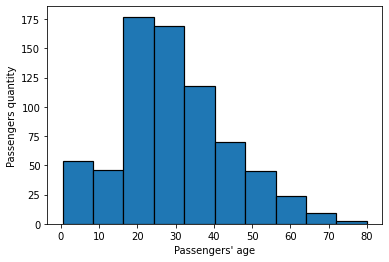

In [ ]:
plt.hist(data['Age'], edgecolor='black', linewidth=1.2);
plt.xlabel('Passengers\' age' );
plt.ylabel('Passengers quantity');

Видим что в этом рейсе было много молодых людей. Проверим есть ли зависимость вероятности спасения от возраста

In [ ]:
survived = data.loc[data['Survived'] == 1]
deceased = data.loc[data['Survived'] == 0]
print('Средний возраст выживших пассажиров: {:.0f} лет'.format(survived['Age'].mean()))
print('Средний возраст погибших пассажиров: {:.0f} лет'.format(deceased['Age'].mean()))

Средний возраст выживших пассажиров: 28 лет
Средний возраст погибших пассажиров: 31 лет


Небольшое различие есть, смотрим распределение возраста в каждой категории:

Text(0.5, 1.0, 'Survived')

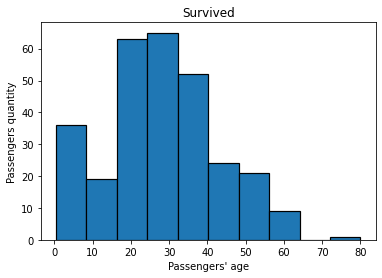

In [ ]:
plt.hist(survived['Age'], edgecolor='black', linewidth=1.2);
plt.xlabel('Passengers\' age' );
plt.ylabel('Passengers quantity');
plt.title('Survived')

Text(0.5, 1.0, 'Deceased')

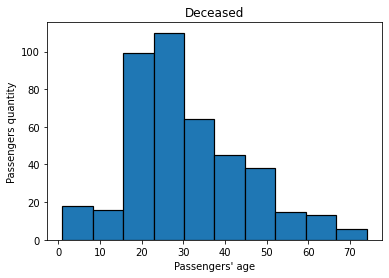

In [ ]:
plt.hist(deceased['Age'], edgecolor='black', linewidth=1.2);
plt.xlabel('Passengers\' age' );
plt.ylabel('Passengers quantity');
plt.title('Deceased')

Распределения отличаются на хвостах, на первом графике видно что детей старались спасать и в итоге их выжило больше, чем погибло. Также видно спасшегося пассажира преклонного возраста, возможно, пожилых тоже старались спасти первыми (гипотеза)

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

Начнём с анализа выживаемости в разных классах

Text(0, 0.5, 'Passengers')

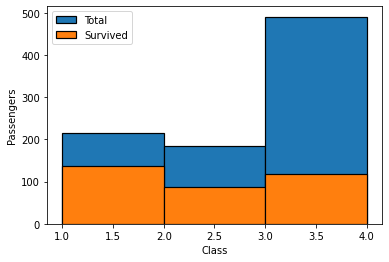

In [ ]:
plt.hist(data['Pclass'], bins = [1,2,3,4], edgecolor='black', linewidth=1.2);
#plt.hist(deceased['Pclass'], bins = [1,2,3,4], edgecolor='black', linewidth=1.2);
plt.hist(survived['Pclass'], bins = [1,2,3,4], edgecolor='black', linewidth=1.2);
#plt.legend(labels = ['Deceased','Survived'])
plt.legend(labels = ['Total', 'Survived']);
plt.xlabel('Class')
plt.ylabel('Passengers')

In [ ]:
survived_1cl = survived.loc[survived['Pclass'] == 1].shape[0]
survived_2cl = survived.loc[survived['Pclass'] == 2].shape[0]
survived_3cl = survived.loc[survived['Pclass'] == 3].shape[0]

total_1cl = data.loc[data['Pclass'] == 1].shape[0]
total_2cl = data.loc[data['Pclass'] == 2].shape[0]
total_3cl = data.loc[data['Pclass'] == 3].shape[0]
print('Доля выживших в первом классе: {:.2%}'.format(survived_1cl / total_1cl))
print('Доля выживших во втором классе: {:.2%}'.format(survived_2cl / total_2cl))
print('Доля выживших в третьем классе: {:.2%}'.format(survived_3cl / total_3cl))

Доля выживших в первом классе: 62.96%
Доля выживших во втором классе: 47.28%
Доля выживших в третьем классе: 24.24%


По графикам и цифрам чётко прослеживается зависимость выживаемости от класса билета (на данный момент пропуски еще не проанализированы, поэтому возможны отклонения, но всё-таки разница значительная). Больше всего погибших в третьем классе. Одна из вероятных причин - более дорогие классы имеют лучшее расположение с легким доступом на палубу, что позволило быстрее выбраться и спастись

Теперь посмотрим на выживаемость в зависимости от порта посадки

In [ ]:
#embarked = data[['Survived', 'Embarked']]
#embarked = pd.get_dummies(embarked['Embarked'])

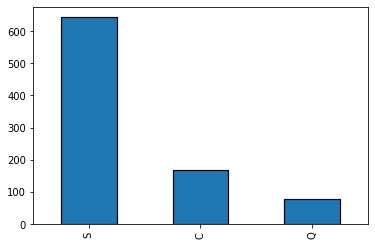

In [ ]:
data['Embarked'].value_counts().plot(kind = 'bar', edgecolor='black', linewidth=1.2)
df2 = survived['Embarked'].value_counts()

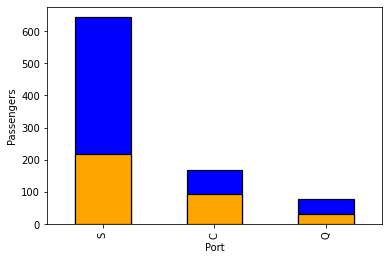

In [ ]:
ax = data['Embarked'].value_counts().plot(kind = 'bar', edgecolor='black', linewidth=1.2, color = 'blue');
ax2 = df2.plot(ax=ax, kind = 'bar', color = 'orange', edgecolor='black', linewidth=1.2);
ax2.set_xlabel('Port');
ax2.set_ylabel('Passengers');

In [ ]:
total_embarked_S = data.loc[data['Embarked'] == 'S'].shape[0]
total_embarked_C = data.loc[data['Embarked'] == 'C'].shape[0]
total_embarked_Q = data.loc[data['Embarked'] == 'Q'].shape[0]
survived_embarked_S = survived.loc[survived['Embarked'] == 'S'].shape[0]
survived_embarked_C = survived.loc[survived['Embarked'] == 'C'].shape[0]
survived_embarked_Q = survived.loc[survived['Embarked'] == 'Q'].shape[0]
print('Доля выживших из {}: {:.2%}'.format('Southampton', survived_embarked_S / total_embarked_S))
print('Доля выживших из {}: {:.2%}'.format('Cherbourg', survived_embarked_C / total_embarked_C))
print('Доля выживших из {}: {:.2%}'.format('Queenstown', survived_embarked_Q / total_embarked_Q))

Доля выживших из Southampton: 33.70%
Доля выживших из Cherbourg: 55.36%
Доля выживших из Queenstown: 38.96%


Внезапно, обнаруживаем что доля выживших из порта Cherbourg выше, чем в остальных двух. Стоит принять эту информацию во внимание и проверить - возможно, в этом городе выше доля пассажиров первых классов и отличие объясняется этим

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [ ]:
 data.isnull().sum() / data.shape[0] * 100

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Видим большое количество пропущенных значение в столбце 'Cabin', т.к. процент довольно высок и вероятнее всего полезной информации эта фича не несёт (т.к. уже есть информация о классе каюты), можно попробовать её просто удалить. Минус такого подхода - при неверной оценке важности фичи, можно дропнуть что-то важное.  
Столбец 'Age' - здесь количество пропущенных значений тоже довольно велико, но мы уже убедились, что возраст связан с шансом выжить, поэтому в данном случае удалять нежелательно. Можно попробовать заполнить средними значениями, минус - нужно подобрать стратегию, как именно заполнять. Иначе можно внести сильные искажения (например, если пропущенные значения в основном у детей, но заполним средним по всем пассажирам, что даст высокое значение)

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [7]:
X = data.drop('Survived', axis = 1)
y = data['Survived']

Обучим очень простые модели на трех признаках: класс, возраст и пол. Класс и пол предварительно преобразуем через pandas.get_dummies. Возраст - заполним средним по всем данным, хотя заполнять значения средним нельзя до разбиения на трейн и тест, т.к. в этом случае есть утечка данных из теста в трейн (но это первая модель, пока так...)

In [8]:
features = ['Pclass', 'Age', 'Sex']
X_train = X[features]
X_train = X_train.merge(pd.get_dummies(X_train['Sex']), on = 'PassengerId')
X_train = X_train.drop('Sex', axis = 1)
X_train = X_train.merge(pd.get_dummies(X_train['Pclass']), on = 'PassengerId')
X_train = X_train.drop('Pclass', axis = 1)
X_train['Age'].fillna(X_train['Age'].mean(), inplace = True)

In [ ]:
#Проверим отсутствие NaN
X_train.isna().sum()

Age       0
female    0
male      0
1         0
2         0
3         0
dtype: int64

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

clf = LogisticRegression(random_state = 42)
scores = cross_val_score(clf, X_train, y, cv=5, scoring = 'accuracy')
print('Mean accuracy for logistic regression: {:.4f}'.format(scores.mean()))
clf_knn = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(clf_knn, X_train, y, cv=5, scoring = 'accuracy')
print('Mean accuracy for kNN: {:.4f}'.format(scores.mean()))

Mean accuracy for logistic regression: 0.7879
Mean accuracy for kNN: 0.7711


**Предсказания**

In [10]:
test_data = pd.read_csv(os.path.join(PATH, 'test.csv')).set_index('PassengerId')
features = ['Pclass', 'Age', 'Sex']
X_test = test_data[features]
X_test = X_test.merge(pd.get_dummies(X_test['Sex']), on = 'PassengerId')
X_test = X_test.drop('Sex', axis = 1)
X_test = X_test.merge(pd.get_dummies(X_test['Pclass']), on = 'PassengerId')
X_test = X_test.drop('Pclass', axis = 1)
X_test['Age'].fillna(X_test['Age'].mean(), inplace = True)

In [12]:
clf.fit(X_train, y)
clf_knn.fit(X_train, y)
logreg = clf.predict(X_test)
knn = clf_knn.predict(X_test)

In [13]:
submission = pd.read_csv(os.path.join(PATH, 'gender_submission.csv'))
submission['Survived'] = logreg
submission.to_csv(os.path.join(PATH,'sub_logreg.csv'), index = False)

submission = pd.read_csv(os.path.join(PATH, 'gender_submission.csv'))
submission['Survived'] = knn
submission.to_csv(os.path.join(PATH,'sub_knn.csv'), index = False)

**Скор на Kaggle для логистической регрессии: 0.75837**

**Скор на Kaggle для kNN: 0.76555 (см. скрин ниже)**



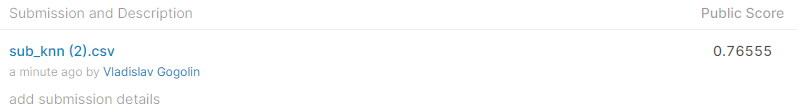

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

**Спойлер**  
Итоговая модель не улучшилась, для kNN и лог. регрессии нужно более детально проработать фичи.  
В итоге **X = 0.5 (скор > 0.76)**

_Дальше можно не читать_...

Попробуем улучшить модель.  
У нас остались неиспользованные фичи 'Fare' и 'SibSp'. Добавим их в модель, 'Fare' в чистом виде ухудшает модель (даже после масштабирования), поэтому я добавил категориальные фичи 'rich', 'poor' на его основе, сам 'Fare' дропнул.  

В первой ячейке повторяем подготовку данных как в предыдущей модели (на всякий случай)

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#scaler.fit(data)
#print(scaler.transform(data))

In [24]:
X = data.drop('Survived', axis = 1)
y = data['Survived']
features = ['Pclass', 'Age', 'Sex', 'Fare']#, 'SibSp']
X_train = X[features]
X_train = X_train.merge(pd.get_dummies(X_train['Sex']), on = 'PassengerId')
X_train = X_train.drop('Sex', axis = 1)
X_train = X_train.merge(pd.get_dummies(X_train['Pclass']), on = 'PassengerId')
X_train = X_train.drop('Pclass', axis = 1)
X_train['Age'].fillna(X_train['Age'].mean(), inplace = True)
#scaler.fit(X_train['Fare'].values.reshape(-1,1))
#X_train['Fare'] = abs(scaler.transform(X_train['Fare'].values.reshape(-1,1)))

test_data = pd.read_csv(os.path.join(PATH, 'test.csv')).set_index('PassengerId')
X_test = test_data[features]
X_test = X_test.merge(pd.get_dummies(X_test['Sex']), on = 'PassengerId')
X_test = X_test.drop('Sex', axis = 1)
X_test = X_test.merge(pd.get_dummies(X_test['Pclass']), on = 'PassengerId')
X_test = X_test.drop('Pclass', axis = 1)
X_test['Age'].fillna(X_test['Age'].mean(), inplace = True)
X_test['Fare'] = X_test['Fare'].fillna(0)
X_test['Fare'] = abs(scaler.transform(X_test['Fare'].values.reshape(-1,1)))

Добавляем категориальные фичи, порог в данном случае подобран вручную. Скорее всего, возможно улучшить

In [ ]:
X_train.loc[X_train['Fare'] <= 23, 'poor'] = int(1)
X_train.loc[X_train['Fare'] > 23, 'poor'] = int(0)
X_train.loc[X_train['Fare'] >= 50, 'rich'] = int(1)
X_train.loc[X_train['Fare'] < 50, 'rich'] = int(0)
X_train['poor'] = X_train['poor'].astype('int')
X_train['rich'] = X_train['rich'].astype('int')
X_train = X_train.drop('Fare', axis = 1)

X_test.loc[X_test['Fare'] <= 23, 'poor'] = int(1)
X_test.loc[X_test['Fare'] > 23, 'poor'] = int(0)
X_test.loc[X_test['Fare'] >= 50, 'rich'] = int(1)
X_test.loc[X_test['Fare'] < 50, 'rich'] = int(0)
X_test['poor'] = X_test['poor'].astype('int')
X_test['rich'] = X_test['rich'].astype('int')
X_test = X_test.drop('Fare', axis = 1)

Испытываем новую модель (kNN), видим улучшение скора на кросс-валидации 0.7711 --> 0.7879

In [25]:
clf_knn = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(clf_knn, X_train, y, cv=5, scoring = 'accuracy')
print('Mean accuracy for kNN: {:.4f}'.format(scores.mean()))

Mean accuracy for kNN: 0.7632


Делаем предсказание и загружаем на Kaggle...

In [26]:
clf_knn.fit(X_train, y)
knn = clf_knn.predict(X_test)
submission = pd.read_csv(os.path.join(PATH, 'gender_submission.csv'))
submission['Survived'] = knn
submission.to_csv(os.path.join(PATH,'sub_knn_tune33d.csv'), index = False)

Ничего хорошего не вышло... скор упал

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

Еще одна проба, с разбиением возраста на группы

In [ ]:
X = data.drop('Survived', axis = 1)
y = data['Survived']
features = ['Pclass', 'Age', 'Sex', 'Fare', 'SibSp']
X_train = X[features]
X_train = X_train.merge(pd.get_dummies(X_train['Sex']), on = 'PassengerId')
X_train = X_train.drop('Sex', axis = 1)
X_train = X_train.merge(pd.get_dummies(X_train['Pclass']), on = 'PassengerId')
X_train = X_train.drop('Pclass', axis = 1)
X_train['Age'].fillna(X_train['Age'].mean(), inplace = True)

test_data = pd.read_csv(os.path.join(PATH, 'test.csv')).set_index('PassengerId')
X_test = test_data[features]
X_test = X_test.merge(pd.get_dummies(X_test['Sex']), on = 'PassengerId')
X_test = X_test.drop('Sex', axis = 1)
X_test = X_test.merge(pd.get_dummies(X_test['Pclass']), on = 'PassengerId')
X_test = X_test.drop('Pclass', axis = 1)
X_test['Age'].fillna(X_test['Age'].mean(), inplace = True)
X_test['Fare'] = X_test['Fare'].fillna(0)

X_train.loc[X_train['Fare'] <= 23, 'poor'] = int(1)
X_train.loc[X_train['Fare'] > 23, 'poor'] = int(0)
X_train.loc[X_train['Fare'] >= 50, 'rich'] = int(1)
X_train.loc[X_train['Fare'] < 50, 'rich'] = int(0)
X_train['poor'] = X_train['poor'].astype('int')
X_train['rich'] = X_train['rich'].astype('int')
X_train = X_train.drop('Fare', axis = 1)

X_test.loc[X_test['Fare'] <= 23, 'poor'] = int(1)
X_test.loc[X_test['Fare'] > 23, 'poor'] = int(0)
X_test.loc[X_test['Fare'] >= 50, 'rich'] = int(1)
X_test.loc[X_test['Fare'] < 50, 'rich'] = int(0)
X_test['poor'] = X_test['poor'].astype('int')
X_test['rich'] = X_test['rich'].astype('int')
X_test = X_test.drop('Fare', axis = 1)

In [ ]:
X_train.loc[X_train['Age'] <= 10, 'age_group'] = int(0)
X_train.loc[(X_train['Age'] > 10) & (X_train['Age'] <= 27), 'age_group'] = int(1)
X_train.loc[X_train['Age'] > 27, 'age_group'] = int(2)
X_train['age_group'] = X_train['age_group'].astype('int')

X_test.loc[X_test['Age'] <= 10, 'age_group'] = int(0)
X_test.loc[(X_test['Age'] > 10) & (X_test['Age'] <= 27), 'age_group'] = int(1)
X_test.loc[X_test['Age'] > 27, 'age_group'] = int(2)
X_test['age_group'] = X_test['age_group'].astype('int')

In [ ]:
clf_knn = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(clf_knn, X_train, y, cv=5, scoring = 'accuracy')
print('Mean accuracy for kNN: {:.4f}'.format(scores.mean()))

Mean accuracy for kNN: 0.7891


In [ ]:
clf_knn.fit(X_train, y)
knn = clf_knn.predict(X_test)
submission = pd.read_csv(os.path.join(PATH, 'gender_submission.csv'))
submission['Survived'] = knn
submission.to_csv(os.path.join(PATH,'sub_knn_tuned_age.csv'), index = False)